In [2]:
# Basic Module
import numpy as np
import pandas as pd

# Graphic Module
import matplotlib.pyplot as plt
import seaborn as sns

# EDA
from scipy.stats import chi2, chi2_contingency, pointbiserialr
from scipy.stats.contingency import association

# ML/DL Algoritm
from sklearn.linear_model import LogisticRegression  # Logistic
from sklearn.linear_model import SGDClassifier  # SGD
from sklearn import svm  # SVM
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Random Forest
from sklearn.ensemble import GradientBoostingClassifier  # GBT
from sklearn.ensemble import AdaBoostClassifier  # Adaboost
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # Decision Tree
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.naive_bayes import GaussianNB  # Naive Bayes

# Encoding
from sklearn.preprocessing import OneHotEncoder

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Oversampler
from imblearn.over_sampling import SMOTE, ADASYN

# Verification
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve, validation_curve, LearningCurveDisplay

# warning message ignore
import warnings
warnings.filterwarnings(action='ignore')

## Data Loading

In [3]:
telco_data = pd.read_csv("./result_data/Modeling_Churn.csv", header=0, encoding='utf-8')

In [4]:
telco_data.head()

,Age,Age Group,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue,Churn Value
0,78,70,0,None,3,1,1,2,Month-to-Month,1,39.65,59.65,1
1,74,70,1,Offer E,3,1,0,4,Month-to-Month,8,80.65,1024.10,1
2,71,70,3,Offer D,2,0,2,4,Month-to-Month,18,95.45,1910.88,1
3,78,70,1,Offer C,2,2,2,4,Month-to-Month,25,98.50,2995.07,1
4,80,80,1,Offer C,2,0,0,4,Month-to-Month,37,76.50,3102.36,1


## Pre-Analysis, EDA

In [5]:
telco_data_cp = telco_data.copy()
telco_data_cp.drop(columns=['Age Group'], inplace=True)

### Object-Object, Chi-Square

In [6]:
categorical_column_list = []
for i in range(len(telco_data_cp.columns)):
    if telco_data_cp[telco_data_cp.columns[i]].dtype == 'object':
        if len(telco_data_cp[telco_data_cp.columns[i]].unique()) <= 100 and len(telco_data_cp[telco_data_cp.columns[i]].unique()) != 1:
            categorical_column_list.append(telco_data_cp.columns[i])

In [7]:
chi_result = pd.DataFrame(columns=['Column', 'Chi-SQ', 'P-value(0.05)', 'H0/H1', 'Corr'])  # 컬럼명, 카이제곱값, p값, 독립/상관 여부, 상관계수
# 카이제곱값이 클수록 예측결과와 실제 결과가 다름을 의미하며, 유의미한 관련성을 가짐
# alpha는 0.05로 작성

for col_name in categorical_column_list:
    ct_result = pd.crosstab(telco_data_cp[str(col_name)], telco_data_cp['Churn Value'])

    chi, p, dof, expected = chi2_contingency(ct_result)

    # 유의수준 0.05, 5%이내
    if p < 0.05:
        R_h0 = '상관'
    else:
        R_h0 = '독립'
    
    if len(ct_result) > 2:  # crosstab 결과로, 어느 축이든 변수가 2개 이상이면 Cramer-V 로 상관 계수를 구함
        corr_value = association(ct_result, method='cramer')
    else:  # x/y 축 모두 변수가 2개이면, phi corr로 상관 계수를 구함
        corr_value = telco_data_cp[(str(col_name)+'_label')].corr(telco_data_cp['Churn Value'])
    
    chi_result.loc[len(chi_result)] = [col_name, chi, p, R_h0, corr_value]


In [8]:
chi_result.sort_values('Corr', ascending=False).reset_index(drop=True)

,Column,Chi-SQ,P-value(0.05),H0/H1,Corr
0,Contract,1445.293243,0.000000e+00,상관,0.453001
1,Membership,481.725489,7.020357e-102,상관,0.261530


### Object-Numeric, Point Biserial

In [9]:
Numeric_column_list = []
for i in range(len(telco_data_cp.columns)):
    if telco_data_cp[telco_data_cp.columns[i]].dtype == 'float64' or telco_data_cp[telco_data_cp.columns[i]].dtype == 'int64':
            Numeric_column_list.append(telco_data_cp.columns[i])

In [10]:
ttest_result = pd.DataFrame(columns=['Column', 'PB-correlation', 'P-value(0.05)', 'H0/H1'])  # 컬럼명, 상관계수, p값, 독립/상관

for col_name in Numeric_column_list:
    ttest, p = pointbiserialr(telco_data_cp['Churn Value'], telco_data_cp[col_name])

    if p < 0.05:
        R_h0 = '상관'
    else:
        R_h0 = '독립'

    ttest_result.loc[len(ttest_result)] = [col_name, ttest, p, R_h0]

In [11]:
ttest_result.sort_values('PB-correlation', ascending=False).reset_index(drop=True)

,Column,PB-correlation,P-value(0.05),H0/H1
0,Churn Value,1.000000,0.000000e+00,상관
1,Combined Product,0.268476,1.478729e-116,상관
2,Monthly Charge,0.193356,2.706646e-60,상관
3,Age,0.115760,1.920497e-22,상관
4,Streaming services,0.071162,2.250868e-09,상관
5,Tech services,-0.173094,1.691428e-48,상관
6,Number of Dependents,-0.218780,4.420027e-77,상관
7,Total Revenue,-0.223003,4.351662e-80,상관
8,Tenure in Months,-0.352861,1.329222e-205,상관
9,Satisfaction Score,-0.754649,0.000000e+00,상관


### EDA Result


In [12]:
test_result_total = pd.DataFrame(columns=['Columns', 'Corr', 'P-Value(0.05)', 'H0/H1', 'Dtype'])

object_columns = chi_result[['Column', 'Corr', 'P-value(0.05)', 'H0/H1']]
object_columns.columns = ['Column', 'Corr', 'P-Value(0.05)', 'H0/H1']
object_columns['Dtype'] = 'Object'

numeric_columns = ttest_result[['Column', 'PB-correlation', 'P-value(0.05)', 'H0/H1']]
numeric_columns.columns = ['Column', 'Corr', 'P-Value(0.05)', 'H0/H1']
numeric_columns['Dtype'] = 'Numeric'

test_result_total = pd.concat([object_columns, numeric_columns], axis=0)

In [13]:
test_result_total.sort_values('Corr', ascending=False).reset_index(drop=True)

,Column,Corr,P-Value(0.05),H0/H1,Dtype
0,Churn Value,1.000000,0.000000e+00,상관,Numeric
1,Contract,0.453001,0.000000e+00,상관,Object
2,Combined Product,0.268476,1.478729e-116,상관,Numeric
3,Membership,0.261530,7.020357e-102,상관,Object
4,Monthly Charge,0.193356,2.706646e-60,상관,Numeric
5,Age,0.115760,1.920497e-22,상관,Numeric
6,Streaming services,0.071162,2.250868e-09,상관,Numeric
7,Tech services,-0.173094,1.691428e-48,상관,Numeric
8,Number of Dependents,-0.218780,4.420027e-77,상관,Numeric
9,Total Revenue,-0.223003,4.351662e-80,상관,Numeric


## Modeling

### Data scaling

In [14]:
# Numeric Only
scaling_data = telco_data_cp.iloc[:,:-1]

Numeric_column_list = []
for i in range(len(scaling_data.columns)):
    if scaling_data[scaling_data.columns[i]].dtype == 'float64' or scaling_data[scaling_data.columns[i]].dtype == 'int64':
            Numeric_column_list.append(scaling_data.columns[i])

numeric_data = scaling_data[Numeric_column_list]

scaler = MinMaxScaler()

scaling_data[Numeric_column_list] = scaler.fit_transform(numeric_data)


In [15]:
scaled_data = scaling_data.copy()
scaling_data

,Age,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue
0,0.967213,0.000000,None,0.50,0.25,0.5,0.333333,Month-to-Month,0.000000,0.212935,0.003202
1,0.901639,0.111111,Offer E,0.50,0.25,0.0,1.000000,Month-to-Month,0.098592,0.620896,0.083855
2,0.852459,0.333333,Offer D,0.25,0.00,1.0,1.000000,Month-to-Month,0.239437,0.768159,0.158013
3,0.967213,0.111111,Offer C,0.25,0.50,1.0,1.000000,Month-to-Month,0.338028,0.798507,0.248680
4,1.000000,0.111111,Offer C,0.25,0.00,0.0,1.000000,Month-to-Month,0.507042,0.579602,0.257652
...,...,...,...,...,...,...,...,...,...,...,...
7038,0.180328,0.000000,None,1.00,0.00,0.0,0.000000,Two Year,1.000000,0.028856,0.252398
7039,0.311475,0.222222,Offer C,0.50,0.75,1.0,0.333333,One Year,0.323944,0.662189,0.232992
7040,0.180328,0.222222,None,0.75,0.50,1.0,1.000000,One Year,1.000000,0.845274,0.788735
7041,0.213115,0.222222,None,0.75,0.25,0.0,0.333333,Month-to-Month,0.140845,0.112935,0.024908


### Data Encoding

In [16]:
# Scaling data load
encoding_data = scaled_data.copy()

# Object Only
categorical_column_list = []
for i in range(len(encoding_data.columns)):
    if encoding_data[encoding_data.columns[i]].dtype == 'object':
        # print(encoding_data.columns[i])
        categorical_column_list.append(encoding_data.columns[i])

for idx, i in enumerate(categorical_column_list):
    # print(i)
    object_data = encoding_data[[i]]

    encoder = OneHotEncoder(sparse=False)
    data_encoded = encoder.fit_transform(object_data)
    # print(encoder.get_feature_names_out())

    # print(encoder.categories_[0])
    encoded_df = pd.DataFrame(data_encoded, columns=[i+ '_' + col for col in encoder.categories_[0]], index=object_data.index)
    # print(encoded_df)
    if idx == 0:
        encoded_data = pd.concat([encoded_df, encoding_data.drop(columns=[i])], axis=1)
    else:
        encoded_data = pd.concat([encoded_df, encoded_data.drop(columns=[i])], axis=1)

In [17]:
encoded_data

,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Membership_None,Membership_Offer A,Membership_Offer B,Membership_Offer C,Membership_Offer D,Membership_Offer E,Age,Number of Dependents,Satisfaction Score,Tech services,Streaming services,Combined Product,Tenure in Months,Monthly Charge,Total Revenue
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.967213,0.000000,0.50,0.25,0.5,0.333333,0.000000,0.212935,0.003202
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.901639,0.111111,0.50,0.25,0.0,1.000000,0.098592,0.620896,0.083855
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.852459,0.333333,0.25,0.00,1.0,1.000000,0.239437,0.768159,0.158013
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.967213,0.111111,0.25,0.50,1.0,1.000000,0.338028,0.798507,0.248680
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.111111,0.25,0.00,0.0,1.000000,0.507042,0.579602,0.257652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.180328,0.000000,1.00,0.00,0.0,0.000000,1.000000,0.028856,0.252398
7039,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.311475,0.222222,0.50,0.75,1.0,0.333333,0.323944,0.662189,0.232992
7040,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.180328,0.222222,0.75,0.50,1.0,1.000000,1.000000,0.845274,0.788735
7041,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.213115,0.222222,0.75,0.25,0.0,0.333333,0.140845,0.112935,0.024908


In [18]:
pre_processed_data = encoded_data.copy()

pre_processed_data = pd.concat([pre_processed_data, telco_data_cp.iloc[:,-1]], axis=1)
pre_processed_data

,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Membership_None,Membership_Offer A,Membership_Offer B,Membership_Offer C,Membership_Offer D,Membership_Offer E,Age,Number of Dependents,Satisfaction Score,Tech services,Streaming services,Combined Product,Tenure in Months,Monthly Charge,Total Revenue,Churn Value
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.967213,0.000000,0.50,0.25,0.5,0.333333,0.000000,0.212935,0.003202,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.901639,0.111111,0.50,0.25,0.0,1.000000,0.098592,0.620896,0.083855,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.852459,0.333333,0.25,0.00,1.0,1.000000,0.239437,0.768159,0.158013,1
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.967213,0.111111,0.25,0.50,1.0,1.000000,0.338028,0.798507,0.248680,1
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.111111,0.25,0.00,0.0,1.000000,0.507042,0.579602,0.257652,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.180328,0.000000,1.00,0.00,0.0,0.000000,1.000000,0.028856,0.252398,0
7039,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.311475,0.222222,0.50,0.75,1.0,0.333333,0.323944,0.662189,0.232992,0
7040,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.180328,0.222222,0.75,0.50,1.0,1.000000,1.000000,0.845274,0.788735,0
7041,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.213115,0.222222,0.75,0.25,0.0,0.333333,0.140845,0.112935,0.024908,0


### Data Split
- x :feature
- y :label

In [19]:
learning_data = pre_processed_data.iloc[:,:-1]
result_data = pre_processed_data.iloc[:,-1]
# learning_data

x_train, x_test, y_train, y_test = train_test_split(learning_data, result_data, test_size=0.2, random_state=100)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5634, 18), (1409, 18), (5634,), (1409,))

### Oversampling

In [20]:
smote = SMOTE(random_state=473, k_neighbors=3)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)

x_train_over.shape, y_train_over.shape, x_train.shape, y_train.shape

((8314, 18), (8314,), (5634, 18), (5634,))

### Modeling - Logistic

In [21]:
model_logistic = LogisticRegression()
model_logistic.fit(x_train, y_train)

predict_result = model_logistic.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_logistic, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9375443577004968 
val : 0.9510117145899895


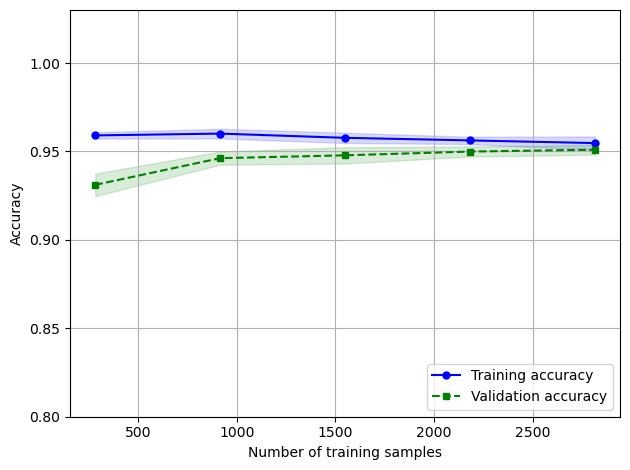

In [22]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_logistic, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [23]:
# Oversampling data
model_logistic.fit(x_train_over, y_train_over)

predict_result = model_logistic.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_logistic, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9261887863733144 
val : 0.9510117145899895


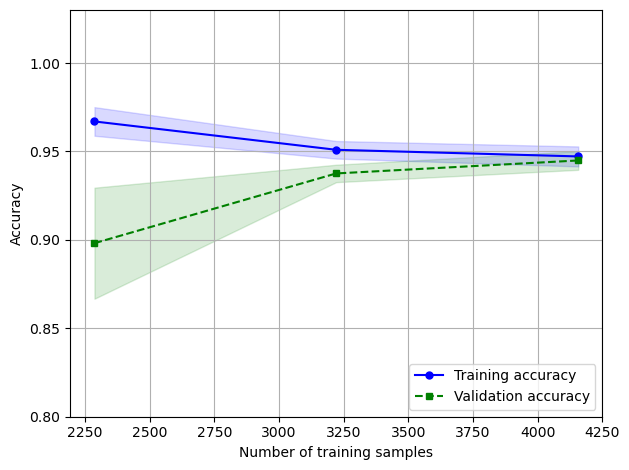

In [24]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_logistic, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

### Modeling - SVM

In [25]:
model_svm = svm.SVC(kernel='linear', C=1, probability=True)
model_svm.fit(x_train, y_train)

predict_result = model_svm.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_svm, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9297374024130589 
val : 0.9428470003549876


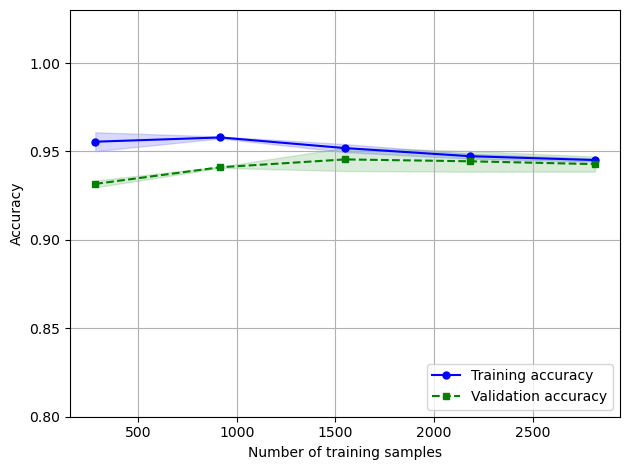

In [26]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_svm, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [27]:
# Oversampling data
model_svm.fit(x_train_over, y_train_over)

predict_result = model_svm.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_svm, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9268985095812633 
val : 0.9428470003549876


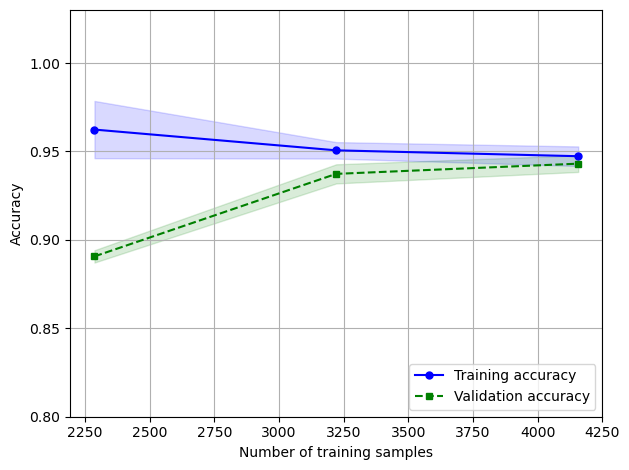

In [28]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_svm, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [29]:
model_svm_rbf = svm.SVC(kernel='rbf', probability=True)
model_svm_rbf.fit(x_train, y_train)

predict_result = model_svm_rbf.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_svm_rbf, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9418026969481902 
val : 0.9503017394391197


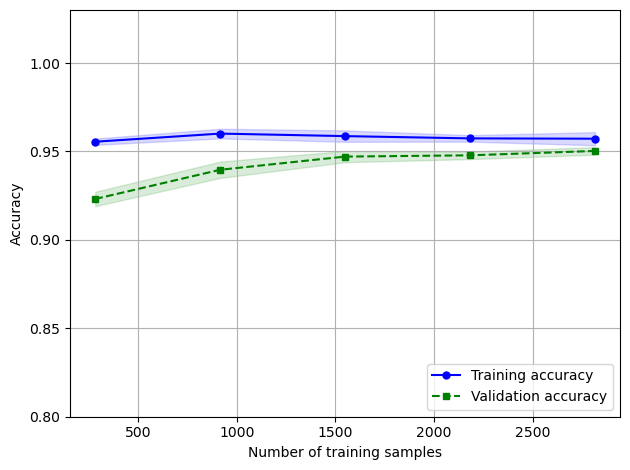

In [30]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_svm_rbf, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [31]:
# Oversampling data
model_svm_rbf.fit(x_train_over, y_train_over)

predict_result = model_svm_rbf.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_svm_rbf, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9311568488289567 
val : 0.9503017394391197


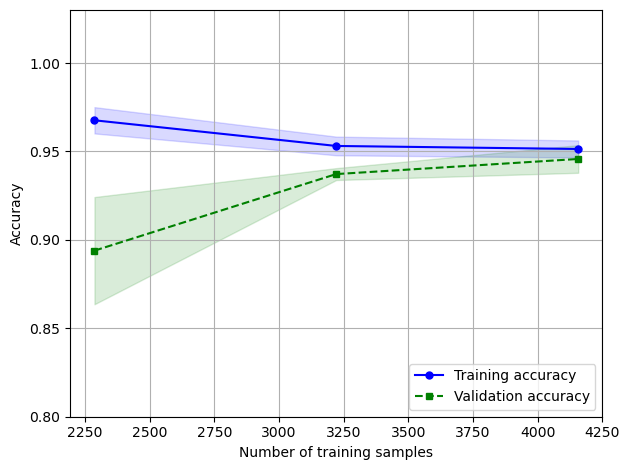

In [32]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_svm_rbf, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - Random Forest

In [33]:
model_rf = RandomForestClassifier(random_state=100)
model_rf.fit(x_train, y_train)

predict_result = model_rf.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_rf, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9474804826117814 
val : 0.9536741214057508


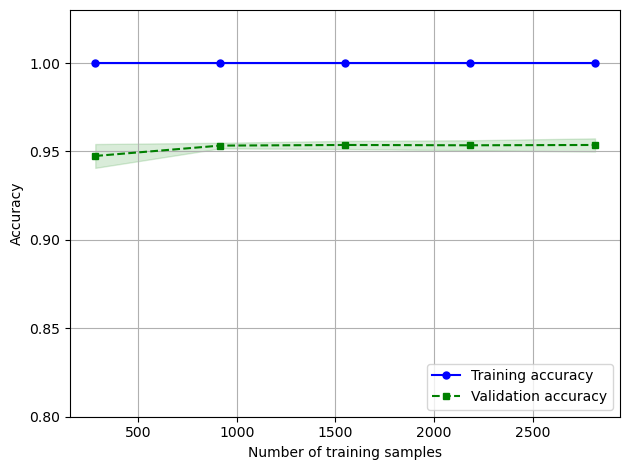

In [34]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_rf, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [35]:
# Oversampling data
model_rf.fit(x_train_over, y_train_over)

predict_result = model_rf.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_rf, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.943222143364088 
val : 0.9536741214057508


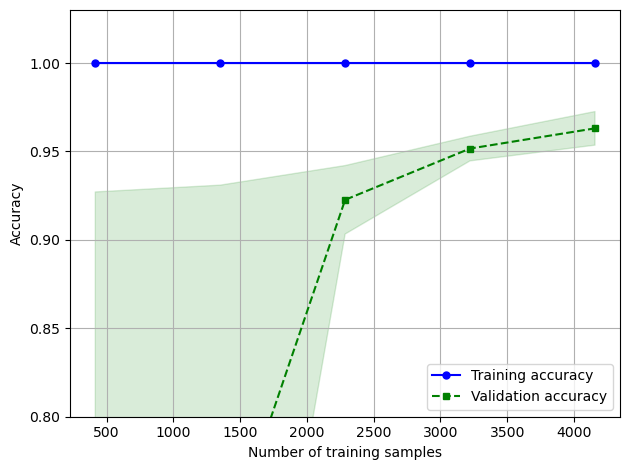

In [36]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_rf, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - DecisionTree

In [37]:
model_dt = DecisionTreeClassifier(random_state=100)
model_dt.fit(x_train, y_train)

predict_result = model_dt.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_dt, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.92902767920511 
val : 0.9361022364217253


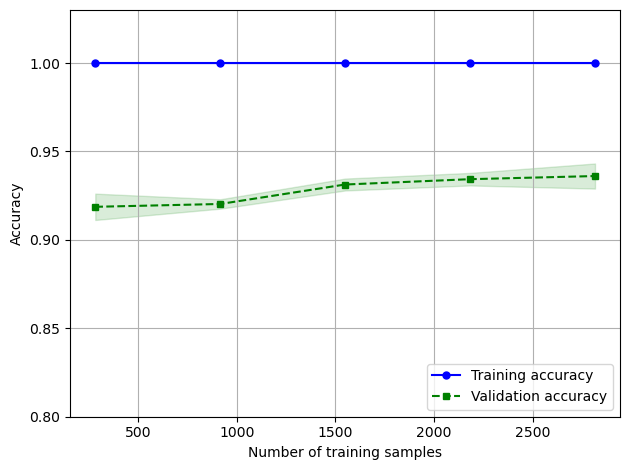

In [38]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_dt, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [39]:
# Oversampling data
model_dt.fit(x_train_over, y_train_over)

predict_result = model_dt.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_dt, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9318665720369056 
val : 0.9361022364217253


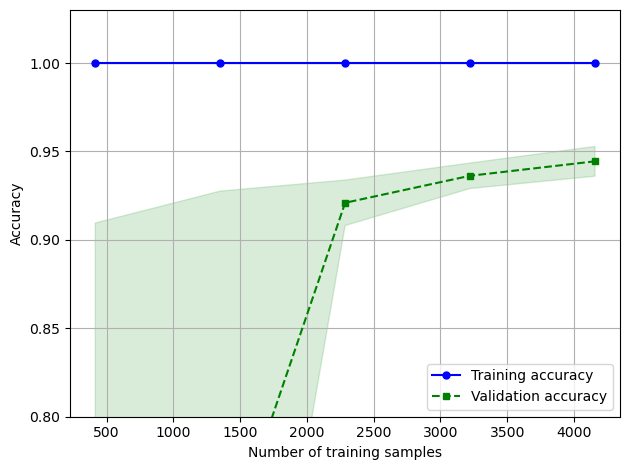

In [40]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_dt, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - KNN

In [41]:
model_kn = KNeighborsClassifier()
model_kn.fit(x_train, y_train)

predict_result = model_kn.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_kn, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.915542938254081 
val : 0.9222577209797658


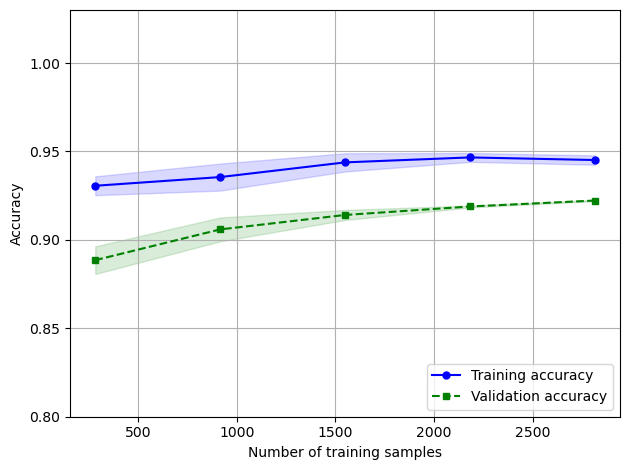

In [42]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_kn, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [43]:
# Oversampling data
model_kn.fit(x_train_over, y_train_over)

predict_result = model_kn.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_kn, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.8985095812633073 
val : 0.9222577209797658


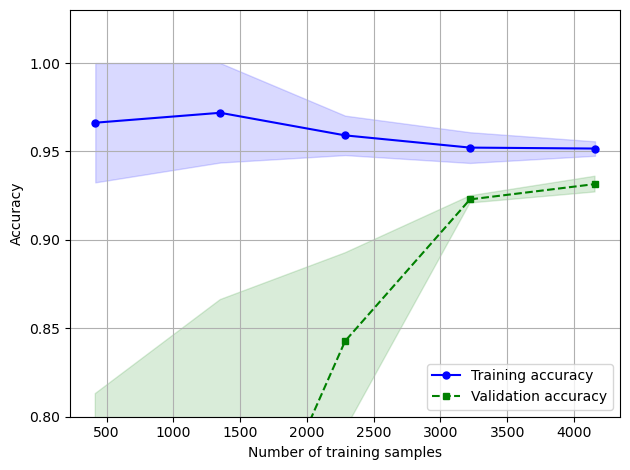

In [44]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_kn, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - Naive Bayes

In [45]:
model_nb = GaussianNB()
model_nb.fit(x_train, y_train)

predict_result = model_nb.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_nb, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.8481192334989354 
val : 0.8383031593894213


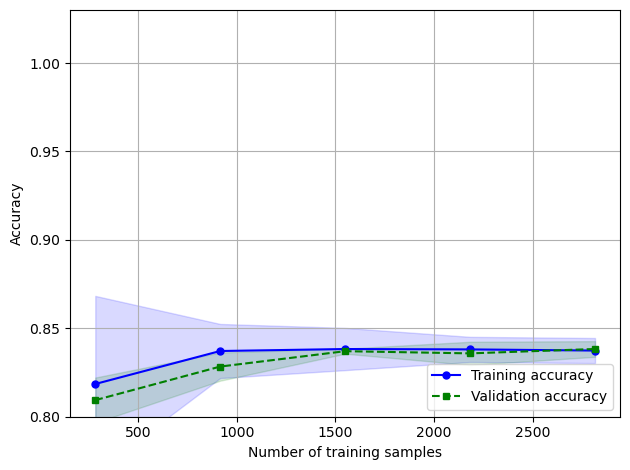

In [46]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_nb, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [47]:
# Oversampling data
model_nb.fit(x_train_over, y_train_over)

predict_result = model_nb.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_nb, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.8388928317955997 
val : 0.8383031593894213


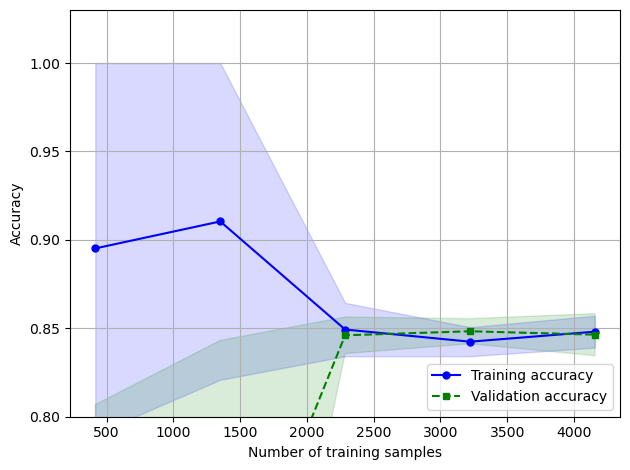

In [48]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_nb, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - GBT

In [49]:
model_gbt = GradientBoostingClassifier(random_state=100)
model_gbt.fit(x_train, y_train)

predict_result = model_gbt.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_gbt, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9474804826117814 
val : 0.9550940717074903


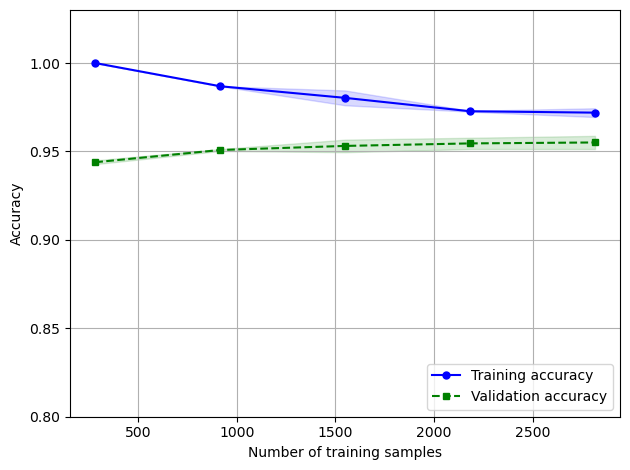

In [50]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_gbt, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [51]:
# Oversampling data
model_gbt.fit(x_train_over, y_train_over)

predict_result = model_gbt.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_gbt, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9347054648687012 
val : 0.9550940717074903


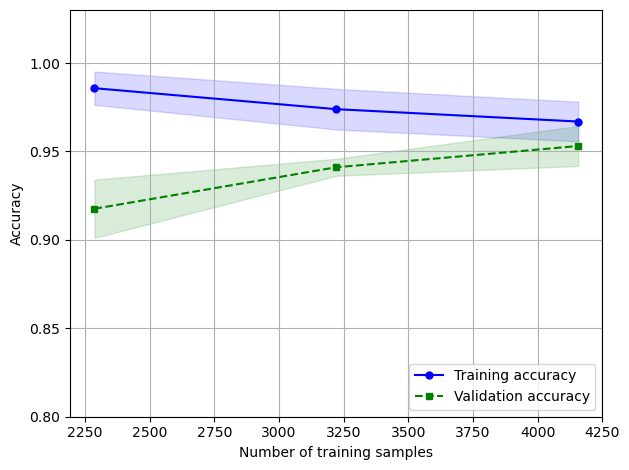

In [52]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_gbt, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - SGD

In [53]:
model_sgd = SGDClassifier(random_state=100)
model_sgd.fit(x_train, y_train)

predict_result = model_sgd.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_sgd, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9119943222143364 
val : 0.9421370252041179


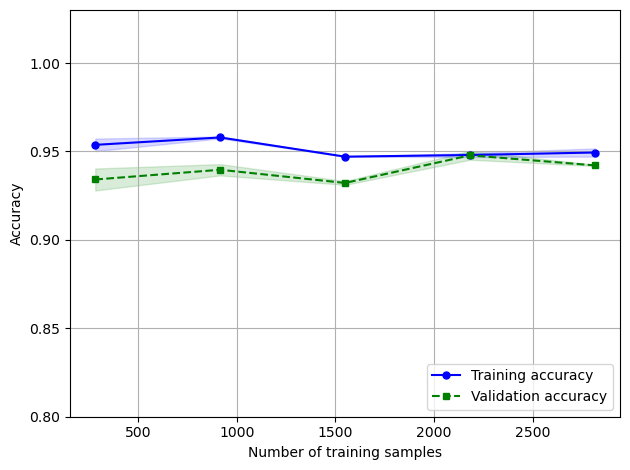

In [54]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_sgd, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [55]:
# Oversampling data
model_sgd.fit(x_train_over, y_train_over)

predict_result = model_sgd.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_sgd, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.915542938254081 
val : 0.9421370252041179


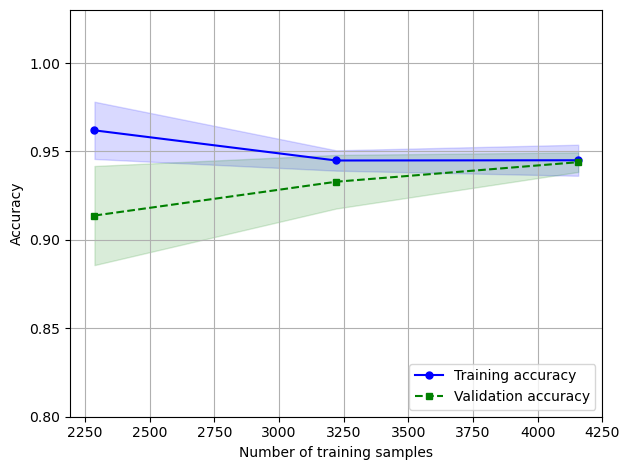

In [56]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_sgd, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### Modeling - Adaboost

In [57]:
model_ada = AdaBoostClassifier(random_state=100)
model_ada.fit(x_train, y_train)

predict_result = model_ada.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_ada, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9460610361958836 
val : 0.9513667021654242


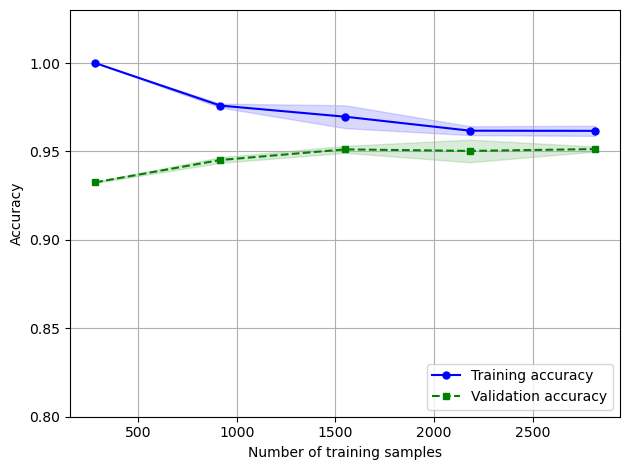

In [58]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_ada, X=x_train, y=y_train, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


In [59]:
# Oversampling data
model_ada.fit(x_train_over, y_train_over)

predict_result = model_ada.predict(x_test)
acc_score = accuracy_score(y_test, predict_result)
val_score = cross_val_score(model_ada, x_train, y_train, cv=2)
print("acc :", acc_score, "\nval :", val_score.mean())

acc : 0.9375443577004968 
val : 0.9513667021654242


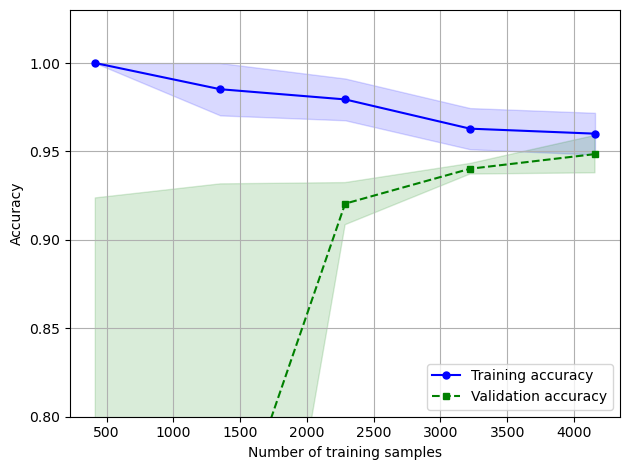

In [60]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model_ada, X=x_train_over, y=y_train_over, cv=2, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


### One-page plot

In [61]:
def learn_vali_plot(axes, rows, cols, datas_num):
    models = [[model_logistic,model_logistic,model_svm,model_svm],
    [model_svm_rbf,model_svm_rbf,model_rf,model_rf],
    [model_dt,model_dt,model_kn,model_kn],
    [model_nb,model_nb,model_gbt,model_gbt],
    [model_sgd,model_sgd,model_ada,model_ada]]
    
    models_name = [['model_logistic','model_logistic','model_svm','model_svm'],
    ['model_svm_rbf','model_svm_rbf','model_rf','model_rf'],
    ['model_dt','model_dt','model_kn','model_kn'],
    ['model_nb','model_nb','model_gbt','model_gbt'],
    ['model_sgd','model_sgd','model_ada','model_ada']]

    datas = [[x_train, y_train], [x_train_over, y_train_over]]
    
    datas_name = [['x_train', 'y_train'], ['x_train_over', 'y_train_over']]

    train_sizes, train_scores, test_scores = learning_curve(estimator=models[rows][cols], X=datas[datas_num][0], y=datas[datas_num][1], cv=2, n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    axes[rows, cols].plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
    axes[rows, cols].fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

    axes[rows, cols].plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
    axes[rows, cols].fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

    axes[rows, cols].grid()
    axes[rows, cols].set_xlabel('Number of training samples')
    axes[rows, cols].set_ylabel('Accuracy')

    if datas_name[datas_num][0] == 'x_train':
        axes[rows, cols].set_title(models_name[rows][cols])
    else:
        axes[rows, cols].set_title(models_name[rows][cols]+'_Oversampling')

    # axes[rows, cols].legend(loc='lower right')
    # axes[rows, cols].ylim([0.8, 1.03])
    # axes[rows, cols].tight_layout()


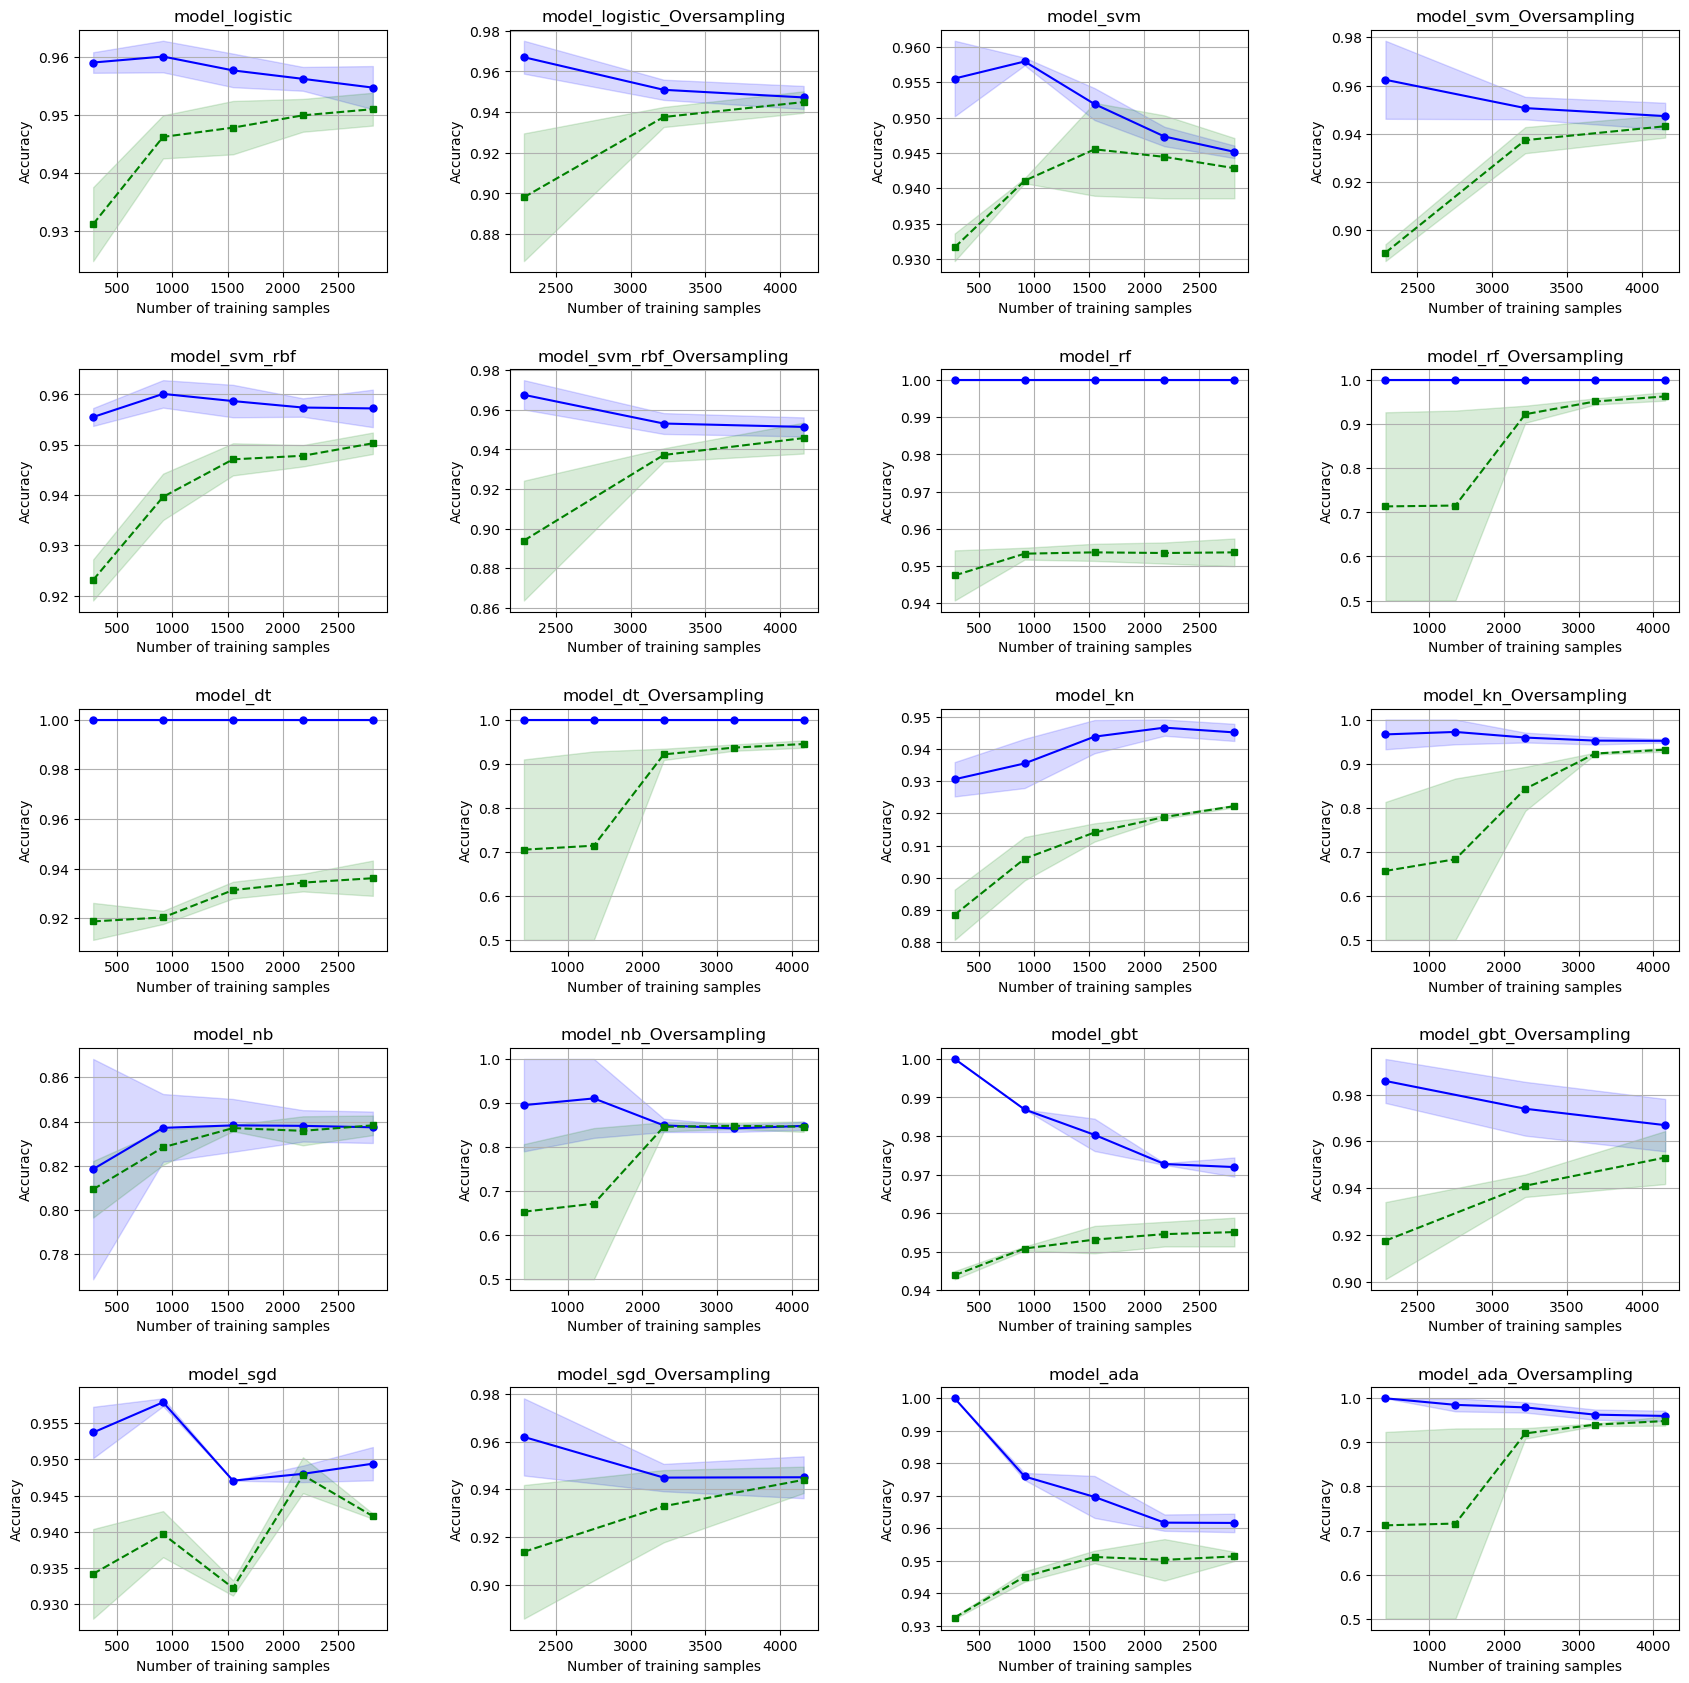

In [62]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20,20))

for i in range(5):
    for j, k in zip(range(4), [0,1,0,1]):
        # print(i, j, k)
        learn_vali_plot(ax, i, j, k)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
plt.show()